# Web Scraping and EDA in Python 3 using Requests, BeautifulSoup, Pandas, Matplotlib, Seaborn

# Source: 
## Thomas Brinkhoff: City Population, http://www.citypopulation.de

In this jupyter notebook I will try to explain how to scrape content from a website using BeautifulSoup and Requests libraries.

Please note there might be some policies and rules for a website for using the data. So before you do the web scraping please do not forget to read the data usage policies.

For this article's purpose I am scraping the data from www.citypopulation.de website which has population statistics for different countries.

Data use policy: http://citypopulation.de/termsofuse.html (DATA -> Population Data)

![Data use terms policy](terms.png)

### The data that I will be extracting in this jupyter notebook is for Oceania -> NEW ZEALAND http://citypopulation.de/en/newzealand/
- I am only scraping data for North and South Islands (excluded Chatham islands)
- North island: http://citypopulation.de/en/newzealand/northisland/
- South island: http://citypopulation.de/en/newzealand/southisland/

---
## Let us scrape the website and fetch the information using requests and beautifulsoup libraries
---

## 1. Scraping website

##### Python environment versions (for reference)

In [5]:
!python --version

Python 3.7.0


In [6]:
!pip --version

pip 19.3.1 from c:\python37\lib\site-packages\pip (python 3.7)



In [10]:
# Importing libraries
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [14]:
print('Requests version: {}'.format(requests.__version__))
print('BeautifulSoup version: {}'.format(bs4.__version__))
print('Pandas version: {}'.format(pd.__version__))

Requests version: 2.19.1
BeautifulSoup version: 4.7.1
Pandas version: 0.23.4


In [19]:
# URLs to scrape
# This is a dictionary object with URLs. 
# We will use this dictionary to scrape information for each url at a time.
urls = {
    'north': 'http://citypopulation.de/en/newzealand/northisland',
    'south': 'http://citypopulation.de/en/newzealand/southisland/'
}

In [20]:
# Using requests to get the information
output = requests.get(urls['north'])
print(output)

<Response [200]>


#### If you see a HTTP status code 200, meaning our request was a success

#### Reference link here: https://en.wikipedia.org/wiki/List_of_HTTP_status_codes

In [50]:
# What's in the output?
# Let's output upto 200 characters 
output.text[:200]

'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n<meta charset="utf-8">\r\n<meta name="description" content="North Island (New Zealand): Regions &amp; Settlements with population statistics, charts and maps."'

In [52]:
print(len(output.text))
print(type(output.text))

233654
<class 'str'>


#### As you see the output above, output.text has the html tags and content of the webpage.

#### Please know that you need some understanding of HTML and tags.

#### Now let's use BeautifulSoup to parse the output.text string.

In [26]:
bs_output = BeautifulSoup(markup=output.text, features="html.parser")

In [53]:
len(bs_output.contents)

7

In [54]:
type(bs_output.contents)

list

In [47]:
bs_output.contents[:2]

['html', '\n']

#### Feel free to print the whole output of the contents
#### bs_output.contents displays the html tags and content of the URL

The beauty of BeautifulSoup's parser is that you can interact with each elements and parts of html tags including classes and id values.

You might wonder wonder what is the difference between requests' output.text and bs4's bs_output.contents?
- Well requests output is a single string vs bs4's output is a list of objects

Example below:

In [49]:
bs_output.find_all('a')[:5]

[<a href="/">Home</a>,
 <a href="/Oceania.html" itemprop="url"><span itemprop="name">Oceania</span></a>,
 <a href="/en/newzealand/" itemprop="url"><span itemprop="name">New Zealand</span></a>,
 <a href="javascript:cp.changePageLang('en','de')"><img alt="" src="/images/icons/de.svg" title="Deutsch"/></a>,
 <a href="javascript:openMap()"><img alt="Show Map" id="smap" src="/images/smaps/newzealand-cities.png" title="Show Map"/></a>]

#### You see the output above? 

I've printed 5 items from the list output of BeautifulSoup's find_all function. I passed <a> tag as 'a' to find all <a> tag elements in the bs_output. Likewise you can extract and play around with all the html tags and their contents.
    
#### Before we do further extraction let us try to understand which parts of our URL page we would like to extract the data from.

# 2. Exploring HTML content and extraction

![Table data](table.png)

In [56]:
# Our data is in the <table> tag with id='ts'
#
table_output = bs_output.find(name='table', attrs={'id': 'ts'})

In [59]:
table_output.contents[:2] # prints a list of tag elements

['\n', <thead>
 <tr id="tsh"><th class="rname" data-coltype="name" onclick="javascript:sort('ts',0,false)"><a href="javascript:sort('ts',0,false)">Name</a></th>
 <th class="rstatus" data-coltype="status" onclick="javascript:sort('ts',1,false)"><a href="javascript:sort('ts',1,false)">Status</a></th><th class="radm rarea" data-coltype="adm" onclick="javascript:sort('ts',2,false)"><a href="javascript:sort('ts',2,false)">Region</a></th><th class="rpop prio5" data-coldate="1996-06-30" data-colhead="E 1996-06-30" data-coltype="pop" onclick="javascript:sort('ts',3,true)"><a href="javascript:sort('ts',3,true)">Population</a><br/><span class="unit">Estimate<br/>1996-06-30</span></th><th class="rpop prio4" data-coldate="2001-06-30" data-colhead="E 2001-06-30" data-coltype="pop" onclick="javascript:sort('ts',4,true)"><a href="javascript:sort('ts',4,true)">Population</a><br/><span class="unit">Estimate<br/>2001-06-30</span></th><th class="rpop prio3" data-coldate="2006-06-30" data-colhead="E 2006-

In [66]:
# Extracting column names from <tr> tag
[x.text for x in table_output.find_all('th')] # outputs a list of values of the <th> elements in the table output

['Name',
 'Status',
 'Region',
 'PopulationEstimate1996-06-30',
 'PopulationEstimate2001-06-30',
 'PopulationEstimate2006-06-30',
 'PopulationEstimate2013-06-30',
 'PopulationEstimate2018-06-30',
 '\xa0']

#### Notice the output above, we don't need the last value

In [79]:
# Append the column names into table_columns empty list
#
table_columns = [x.get_text() for x in table_output.find_all('th')][:-1]
table_columns

['Name',
 'Status',
 'Region',
 'PopulationEstimate1996-06-30',
 'PopulationEstimate2001-06-30',
 'PopulationEstimate2006-06-30',
 'PopulationEstimate2013-06-30',
 'PopulationEstimate2018-06-30']

In [84]:
# Extracting table output which is in <tbody> tag
#
table_body = table_output.find_all('tbody')

#### Feel free to print the output of table_body, it will be long output result

In [98]:
north_island_output = []
for item in table_body:
    rows = item.find_all('tr') # extracts <tr> elements in <tbody>
    for row in rows:
        td = row.find_all('td') # extracts <td> elements in each row i.e. <tr>
        td_values = [val.text for val in td] # extracts value of each <td>
        north_island_output.append(td_values) # appends values to the list

In [99]:
north_island_output[1]

['Algies Bay',
 'Rural Settlement',
 'Auckland',
 '550',
 '690',
 '800',
 '870',
 '980',
 '→']

#### Again, in the output above we don't need the last value, so let's fix that

In [100]:
north_island_output = []
for item in table_body:
    rows = item.find_all('tr') # extracts <tr> elements in <tbody>
    for row in rows:
        td = row.find_all('td') # extracts <td> elements in each row i.e. <tr>
        td_values = [val.text for val in td] # extracts value of each <td>
        north_island_output.append(td_values[:-1]) # appends values to the list, also excludes the last value that is not needed

In [101]:
north_island_output[1]

['Algies Bay',
 'Rural Settlement',
 'Auckland',
 '550',
 '690',
 '800',
 '870',
 '980']

#### That's it, we have our table column names and the table data append those two into a dataframe

In [102]:
table_columns

['Name',
 'Status',
 'Region',
 'PopulationEstimate1996-06-30',
 'PopulationEstimate2001-06-30',
 'PopulationEstimate2006-06-30',
 'PopulationEstimate2013-06-30',
 'PopulationEstimate2018-06-30']

In [103]:
north_data = pd.DataFrame(
    data=north_island_output,
    columns=table_columns
)

In [104]:
north_data.head()

,Name,Status,Region,PopulationEstimate1996-06-30,PopulationEstimate2001-06-30,PopulationEstimate2006-06-30,PopulationEstimate2013-06-30,PopulationEstimate2018-06-30
0,Ahipara,Rural Settlement,Northland,930,"1,050","1,120","1,130","1,180"
1,Algies Bay,Rural Settlement,Auckland,550,690,800,870,980
2,Arapuni,Rural Settlement,Waikato,290,260,230,250,260
3,Ashhurst,Small Urban Area,Manawatu-Wanganui,"2,530","2,520","2,510","2,750","2,990"
4,Athenree,Rural Settlement,Bay of Plenty,510,530,630,700,740


### We can follow the same procedure above for south island data as well. 

### For a better approach let us put the whole process using a function.

In [105]:
# Importing libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Variables
south_island_output = []
north_island_output = []
table_columns = []

# URLs for North and South islands
urls = {
    'north': 'http://citypopulation.de/en/newzealand/northisland',
    'south': 'http://citypopulation.de/en/newzealand/southisland/'
}

# Function that downloads the data
def download_data():
    """
    Function extracts td values by looping each child element of the parent.
    
    Two empty lists south_island_output and north_island_output are initialised.
    
    A urls dictionary object with north island and south island urls is also initialised.
    
    Pseudo code:
    - for each item in the dictionary
        - connect to the url
            - if success (response code == 200), then loop through the page data
                - for each row_item in body (loop - look for <tr> element):
                    - for each row in the row_item (loop and look for <td> element):
                        - for each <td> element, extract the text value
                            - finally append those text values into output list
    """    
    for url in urls:
        print(url, urls[url])
        
        ## response
        response = requests.get(urls[url])
        
        if response.status_code == 200:
            print('Response code is 200. Success!')
            try:
                ## web scraping
                soup = BeautifulSoup(response.text, "html.parser")
                table = soup.find(name='table', attrs={'id': 'ts'})
                table_columns.append([x.get_text() for x in table.find_all('th')][:-1])
                body = table.find_all('tbody')
                for item in body:
                    rows = item.find_all('tr')    
                    for row in rows:
                        td = row.find_all('td')
                        td_values = [val.text for val in td]
                        if url == 'north':
                            north_island_output.append(td_values[:-1]) # excluding last column that has an arrow as a value
                        else:
                            south_island_output.append(td_values[:-1]) # excluding last column that has an arrow as a value
            except Exception as ex:
                print(str(ex))
        else:
            print('Oops! {0}'.format(response.status_code))

In [106]:
download_data()

north http://citypopulation.de/en/newzealand/northisland
Response code is 200. Success!
south http://citypopulation.de/en/newzealand/southisland/
Response code is 200. Success!


In [108]:
table_columns[0]

['Name',
 'Status',
 'Region',
 'PopulationEstimate1996-06-30',
 'PopulationEstimate2001-06-30',
 'PopulationEstimate2006-06-30',
 'PopulationEstimate2013-06-30',
 'PopulationEstimate2018-06-30']

In [110]:
# North island dataframe
north_island_data = pd.DataFrame(data=north_island_output, columns=table_columns[0])

# South island dataframe
south_island_data = pd.DataFrame(data=south_island_output, columns=table_columns[0])

In [111]:
north_island_data.head()

,Name,Status,Region,PopulationEstimate1996-06-30,PopulationEstimate2001-06-30,PopulationEstimate2006-06-30,PopulationEstimate2013-06-30,PopulationEstimate2018-06-30
0,Ahipara,Rural Settlement,Northland,930,"1,050","1,120","1,130","1,180"
1,Algies Bay,Rural Settlement,Auckland,550,690,800,870,980
2,Arapuni,Rural Settlement,Waikato,290,260,230,250,260
3,Ashhurst,Small Urban Area,Manawatu-Wanganui,"2,530","2,520","2,510","2,750","2,990"
4,Athenree,Rural Settlement,Bay of Plenty,510,530,630,700,740


In [112]:
south_island_data.head()

,Name,Status,Region,PopulationEstimate1996-06-30,PopulationEstimate2001-06-30,PopulationEstimate2006-06-30,PopulationEstimate2013-06-30,PopulationEstimate2018-06-30
0,Ahaura,Rural Settlement,West Coast,120,140,110,100,80
1,Akaroa,Rural Settlement,Canterbury,680,610,620,670,630
2,Alexandra,Small Urban Area,Otago,"4,690","4,480","4,940","4,920","5,510"
3,Allanton,Rural Settlement,Otago,220,240,260,260,290
4,Amberley,Small Urban Area,Canterbury,"1,050","1,160","1,340","1,620","1,800"


# 3. EDA

#### For data analysis, let's take out unwanted columns from our dataframes

In [113]:
north_island_data = north_island_data[['Name', 'Status','Region', 'PopulationEstimate2018-06-30']]
south_island_data = south_island_data[['Name', 'Status','Region', 'PopulationEstimate2018-06-30']]

In [114]:
north_island_data.head(2)

,Name,Status,Region,PopulationEstimate2018-06-30
0,Ahipara,Rural Settlement,Northland,"1,180"
1,Algies Bay,Rural Settlement,Auckland,980


In [115]:
south_island_data.head(2)

,Name,Status,Region,PopulationEstimate2018-06-30
0,Ahaura,Rural Settlement,West Coast,80
1,Akaroa,Rural Settlement,Canterbury,630


## 3.1 North island

In [116]:
north_island_data.shape

(350, 4)

#### Some data cleaning

Population column values have "," comma in the values. Let's replace , and convert the column from string to integer type.

In [119]:
north_island_data.dtypes

Name                            object
Status                          object
Region                          object
PopulationEstimate2018-06-30    object
dtype: object

In [123]:
north_island_data['PopulationEstimate2018-06-30'] = north_island_data['PopulationEstimate2018-06-30'].str.replace(',', '')

In [124]:
north_island_data.head()

,Name,Status,Region,PopulationEstimate2018-06-30
0,Ahipara,Rural Settlement,Northland,1180
1,Algies Bay,Rural Settlement,Auckland,980
2,Arapuni,Rural Settlement,Waikato,260
3,Ashhurst,Small Urban Area,Manawatu-Wanganui,2990
4,Athenree,Rural Settlement,Bay of Plenty,740


In [125]:
north_island_data['PopulationEstimate2018-06-30'] = pd.to_numeric(north_island_data['PopulationEstimate2018-06-30'])

In [126]:
north_island_data.dtypes

Name                            object
Status                          object
Region                          object
PopulationEstimate2018-06-30     int64
dtype: object

#### Renaming population column

In [142]:
north_island_data = north_island_data.rename(columns={'PopulationEstimate2018-06-30': 'PopulationEstimate2018'})
north_island_data.head(2)

,Name,Status,Region,PopulationEstimate2018
0,Ahipara,Rural Settlement,Northland,1180
1,Algies Bay,Rural Settlement,Auckland,980


#### Top 10 most populated places in north island

In [152]:
north_island_data.sort_values(by='PopulationEstimate2018', ascending=False).head(10)

,Name,Status,Region,PopulationEstimate2018
6,Auckland,Main Urban Area,Auckland,1467800
333,Wellington,Main Urban Area,Wellington,215400
46,Hamilton,Main Urban Area,Waikato,169300
267,Tauranga,Main Urban Area,Bay of Plenty,135000
105,Lower Hutt,Main Urban Area,Wellington,104900
198,Palmerston North,Large Urban Area,Manawatu-Wanganui,80300
141,Napier,Large Urban Area,Hawke's Bay,62800
219,Porirua,Large Urban Area,Wellington,55500
143,New Plymouth,Large Urban Area,Taranaki,55300
241,Rotorua,Large Urban Area,Bay of Plenty,54500


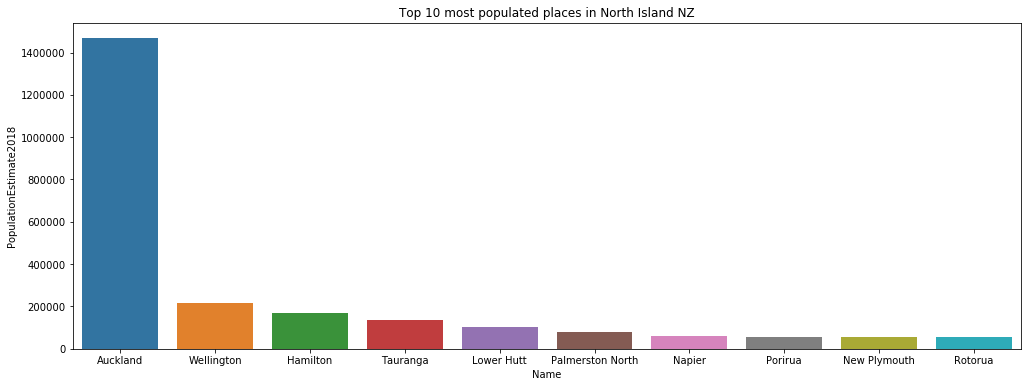

In [179]:
top_10 = north_island_data.sort_values(by='PopulationEstimate2018', ascending=False).head(10)

plt.figure(figsize=(17, 6))
sns.barplot(x='Name', y='PopulationEstimate2018', data=top_10)
plt.title("Top 10 most populated places in North Island NZ")
plt.show()

#### Top 10 least populated places in north island

In [151]:
north_island_data.sort_values(by='PopulationEstimate2018', ascending=True).head(10)

,Name,Status,Region,PopulationEstimate2018
20,Castlepoint,Rural Settlement,Wellington,50
328,Waitotara,Rural Settlement,Taranaki,60
234,Raurimu,Rural Settlement,Manawatu-Wanganui,70
309,Waiinu Beach,Rural Settlement,Taranaki,70
340,Whangapoua,Rural Settlement,Waikato,70
5,Atiamuri,Rural Settlement,Waikato,70
184,Ormondville,Rural Settlement,Manawatu-Wanganui,70
8,Baddeleys Beach - Campbells Beach,Rural Settlement,Auckland,70
324,Waitangi,Rural Settlement,Northland,80
230,Rainbows End,Rural Settlement,Auckland,80


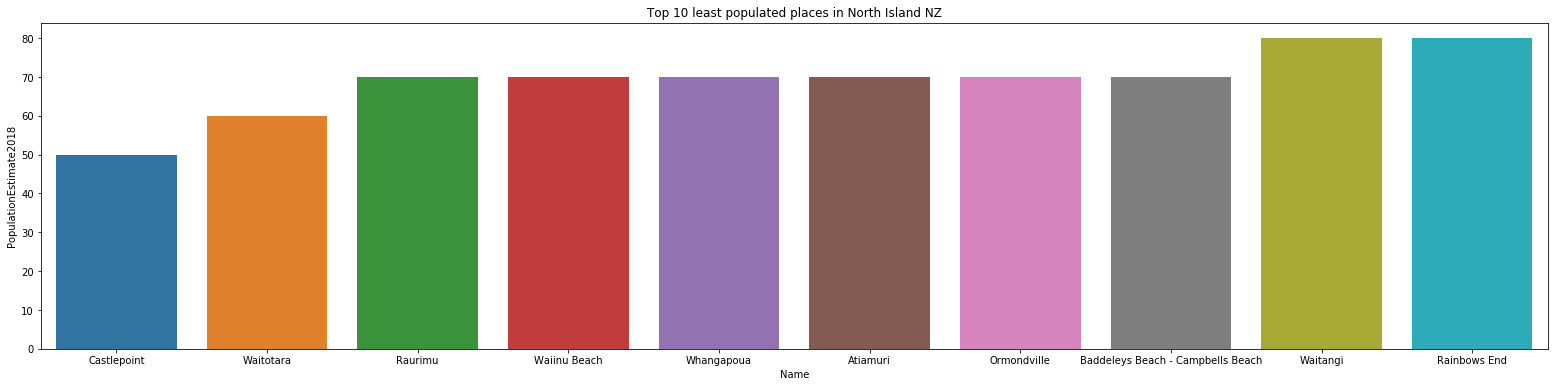

In [178]:
bottom_10 = north_island_data.sort_values(by='PopulationEstimate2018', ascending=True).head(10)

plt.figure(figsize=(27, 6))
sns.barplot(x='Name', y='PopulationEstimate2018', data=bottom_10)
plt.title("Top 10 least populated places in North Island NZ")
plt.show()

#### Population counts grouped by Region

In [270]:
region_totals = north_island_data.groupby('Region')['PopulationEstimate2018'].agg(['sum', 'count'])
region_totals

,sum,count
Region,,
Auckland,1612730,59
Bay of Plenty,259400,38
Gisborne,39320,9
Hawke's Bay,140620,21
Manawatu-Wanganui,199140,50
Northland,109850,58
Taranaki,93240,22
Waikato,353070,77
Wellington,498300,16


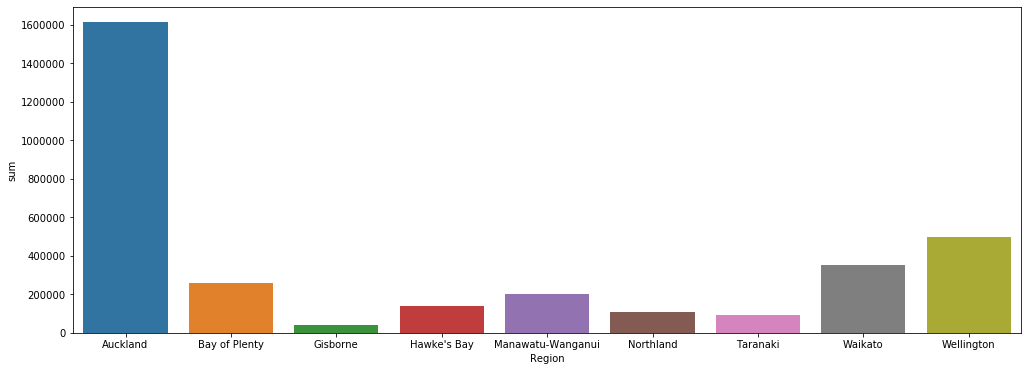

In [271]:
plt.figure(figsize=(17, 6))
sns.barplot(x=region_totals.index, y='sum', data=region_totals)
plt.show()

## 3.2 South island

In [272]:
south_island_data.shape

(227, 4)

#### Some data cleaning

Population column values have "," comma in the values. Let's replace , and convert the column from string to integer type.

In [273]:
south_island_data.dtypes

Name                            object
Status                          object
Region                          object
PopulationEstimate2018-06-30    object
dtype: object

In [274]:
south_island_data['PopulationEstimate2018-06-30'] = south_island_data['PopulationEstimate2018-06-30'].str.replace(',', '')

In [275]:
south_island_data.head()

,Name,Status,Region,PopulationEstimate2018-06-30
0,Ahaura,Rural Settlement,West Coast,80
1,Akaroa,Rural Settlement,Canterbury,630
2,Alexandra,Small Urban Area,Otago,5510
3,Allanton,Rural Settlement,Otago,290
4,Amberley,Small Urban Area,Canterbury,1800


In [276]:
south_island_data['PopulationEstimate2018-06-30'] = pd.to_numeric(south_island_data['PopulationEstimate2018-06-30'])

In [277]:
south_island_data.dtypes

Name                            object
Status                          object
Region                          object
PopulationEstimate2018-06-30     int64
dtype: object

#### Renaming population column

In [278]:
south_island_data = south_island_data.rename(columns={'PopulationEstimate2018-06-30': 'PopulationEstimate2018'})
south_island_data.head(2)

,Name,Status,Region,PopulationEstimate2018
0,Ahaura,Rural Settlement,West Coast,80
1,Akaroa,Rural Settlement,Canterbury,630


#### Top 10 most populated places in south island

In [279]:
south_island_data.sort_values(by='PopulationEstimate2018', ascending=False).head(10)

,Name,Status,Region,PopulationEstimate2018
28,Christchurch,Main Urban Area,Canterbury,377200
40,Dunedin,Main Urban Area,Otago,104500
125,Nelson,Large Urban Area,Nelson,49300
73,Invercargill,Large Urban Area,Southland,48700
195,Timaru,Medium Urban Area,Canterbury,28300
19,Blenheim,Medium Urban Area,Marlborough,26400
11,Ashburton,Medium Urban Area,Canterbury,19600
158,Rangiora,Medium Urban Area,Canterbury,18400
166,Rolleston,Medium Urban Area,Canterbury,16350
154,Queenstown,Medium Urban Area,Otago,15650


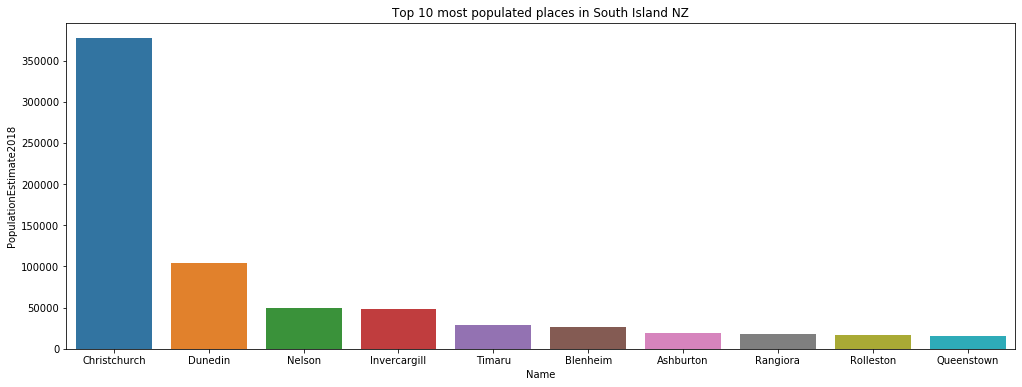

In [283]:
top_10 = south_island_data.sort_values(by='PopulationEstimate2018', ascending=False).head(10)

plt.figure(figsize=(17, 6))
sns.barplot(x='Name', y='PopulationEstimate2018', data=top_10)
plt.title("Top 10 most populated places in South Island NZ")
plt.show()

#### Top 10 least populated places in south island

In [284]:
south_island_data.sort_values(by='PopulationEstimate2018', ascending=True).head(10)

,Name,Status,Region,PopulationEstimate2018
59,Haast,Rural Settlement,West Coast,50
9,Arthur's Pass,Rural Settlement,Canterbury,60
127,Ngakuta Bay,Rural Settlement,Marlborough,60
150,Pounawea,Rural Settlement,Otago,60
112,Milford Huts,Rural Settlement,Canterbury,60
153,Purau,Rural Settlement,Canterbury,60
116,Moana,Rural Settlement,West Coast,70
174,Selwyn Huts,Rural Settlement,Canterbury,70
103,Makikihi,Rural Settlement,Canterbury,80
209,Waipopo,Rural Settlement,Canterbury,80


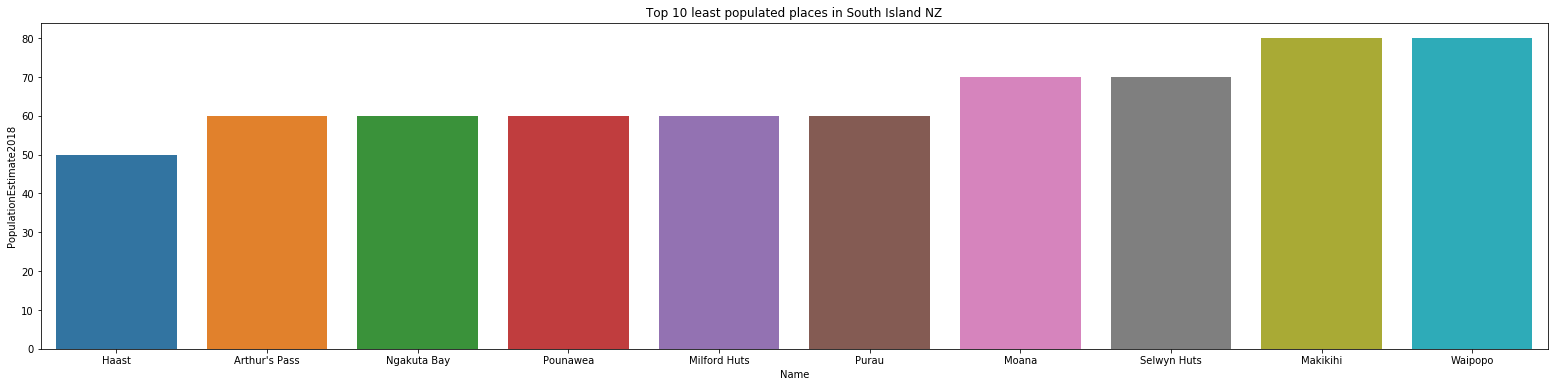

In [285]:
bottom_10 = south_island_data.sort_values(by='PopulationEstimate2018', ascending=True).head(10)

plt.figure(figsize=(27, 6))
sns.barplot(x='Name', y='PopulationEstimate2018', data=bottom_10)
plt.title("Top 10 least populated places in South Island NZ")
plt.show()

#### Population counts grouped by Region

In [286]:
region_totals = south_island_data.groupby('Region')['PopulationEstimate2018'].agg(['sum', 'count'])
region_totals

,sum,count
Region,,
Canterbury,544370,87
Marlborough,37490,17
Nelson,49300,1
Otago,200050,58
Southland,72450,23
Tasman,35640,19
West Coast,23000,22


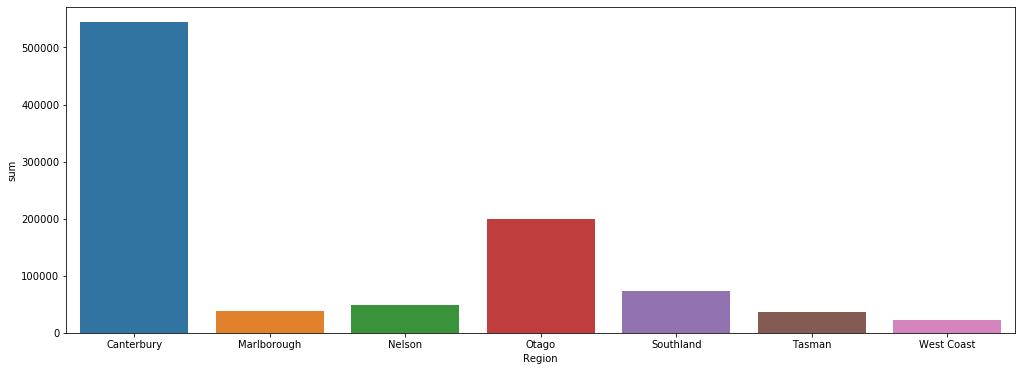

In [288]:
plt.figure(figsize=(17, 6))
sns.barplot(x=region_totals.index, y='sum', data=region_totals)
plt.show()